In [14]:
import os
import sys
import cv2
import open3d as o3d
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import re

### Set Path Variable

In [2]:
BASE_DATA_PATH = "data"
splits_path = "splits"
CLASSES_FILE_PATH = os.path.join(BASE_DATA_PATH, "splits/classes.txt")
VIEWS = "0"
split_name = "test"
what3d_pt_path = "points"
shapenet_pt_path = "shapenet_points"
img_path = "renderings"
NUMS = 10432
index_list = [8127, 9349, 9222, 3671, 9033, 9588, 1213, 9159, 8137, 931, 8179, 8193, 8601, 9181, 8995, 5983]     ## index list of deficient case 
BBOX = np.array([[[0, 0, 0], [1.0, 1.0, 1.0]]])

### Get path list 

In [11]:
class_list = get_class_list()
what3d_ptcloud_path_list = []
shapenet_ptcloud_path_list = []
img_path_list = []
for idx, view in enumerate(VIEWS):
    for clname in class_list:
        f = open(os.path.join(BASE_DATA_PATH, splits_path, 'lists', clname, '%s.txt'%split_name),"r")
        for x in f:
            instance_id = x[:-1]
            what3d_ptcloud_path_list.append(os.path.join(BASE_DATA_PATH, what3d_pt_path, clname, instance_id, "{}.ply".format(VIEWS)))
            shapenet_ptcloud_path_list.append(os.path.join(BASE_DATA_PATH, shapenet_pt_path, clname, instance_id, "ptcloud.ply"))
            img_path_list.append(os.path.join(BASE_DATA_PATH, img_path, clname, instance_id, "{}.png".format(view)))

### Visualization

100%|██████████| 10432/10432 [00:02<00:00, 4789.39it/s]


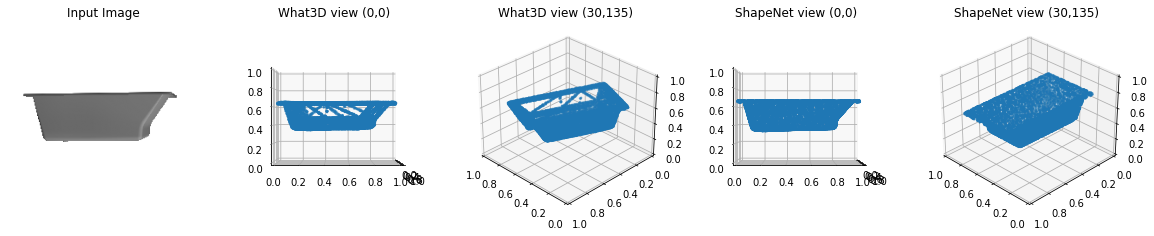

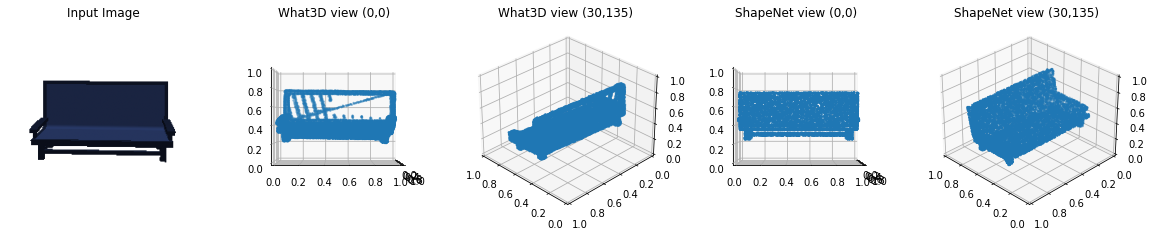

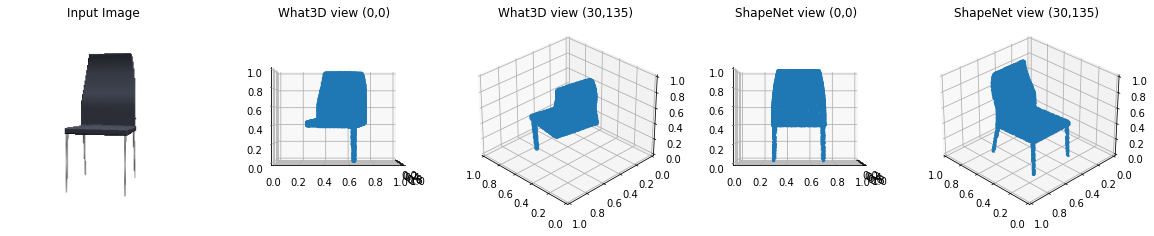

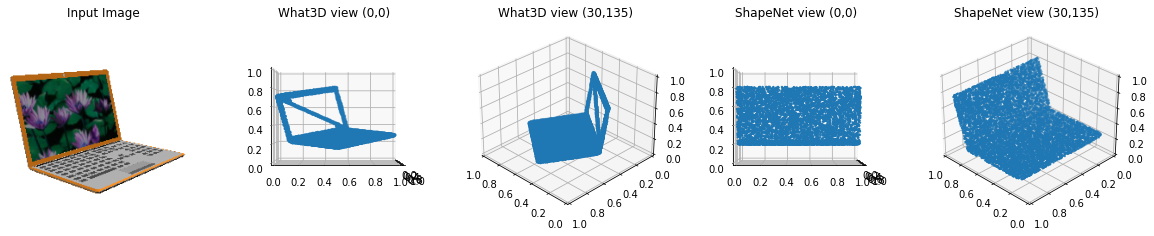

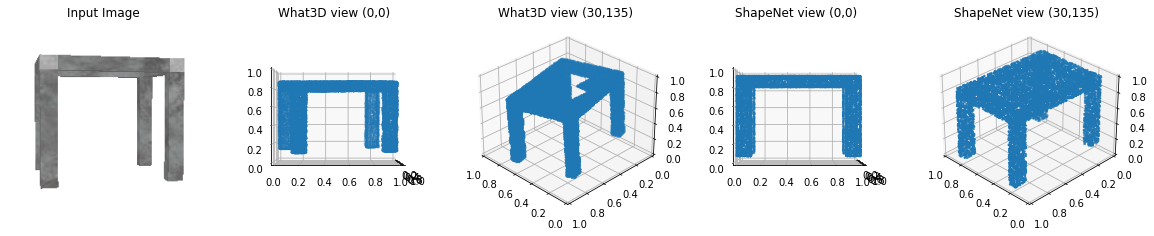

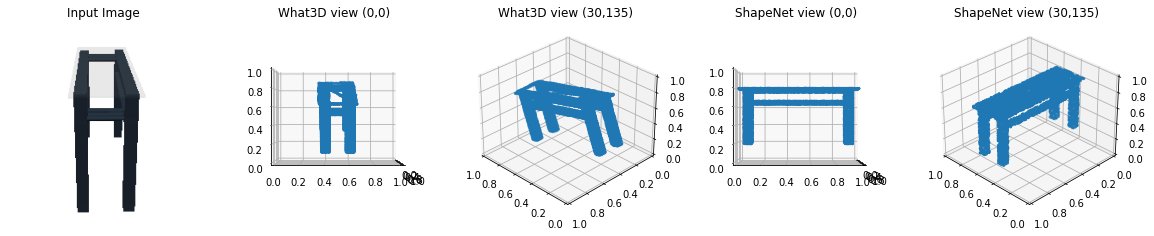

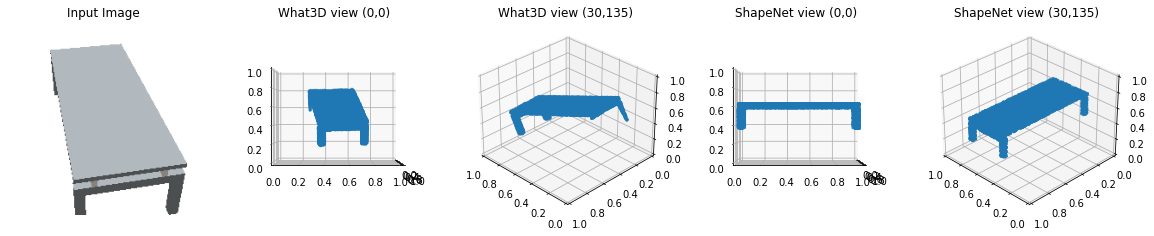

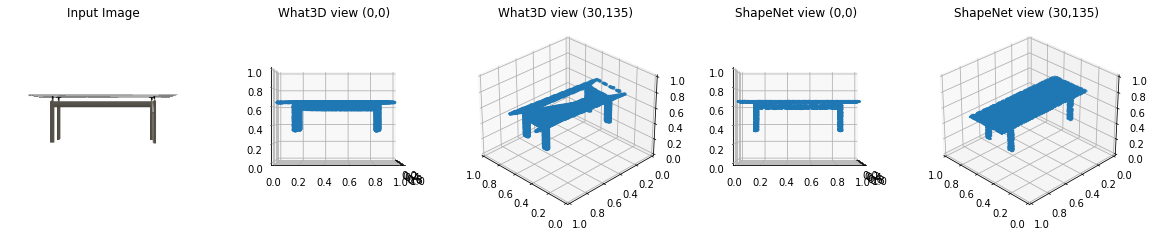

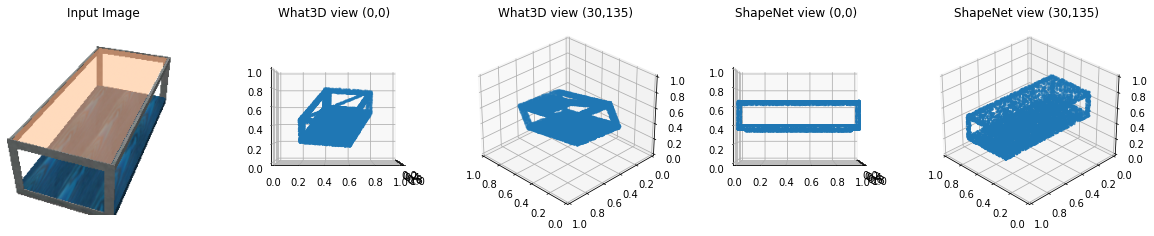

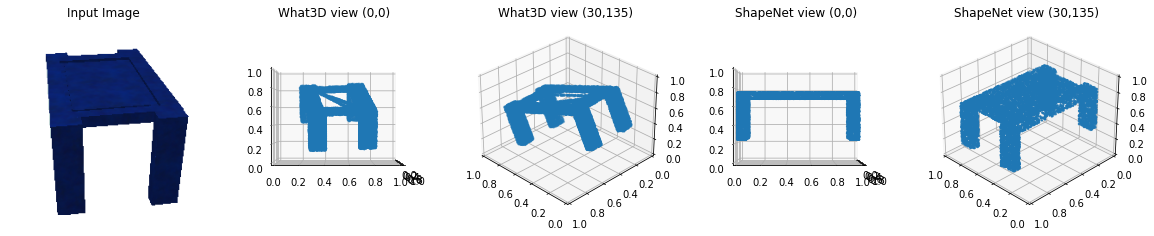

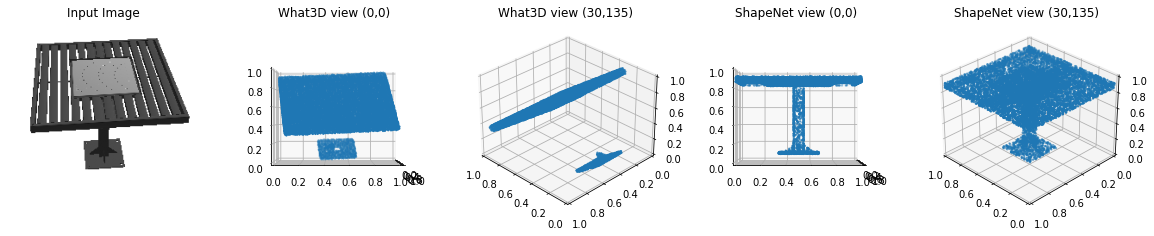

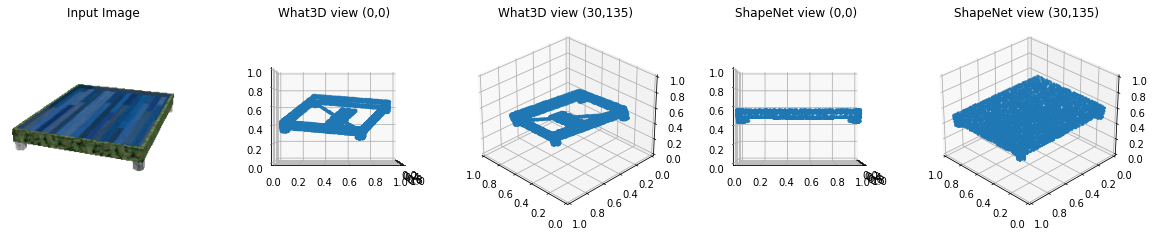

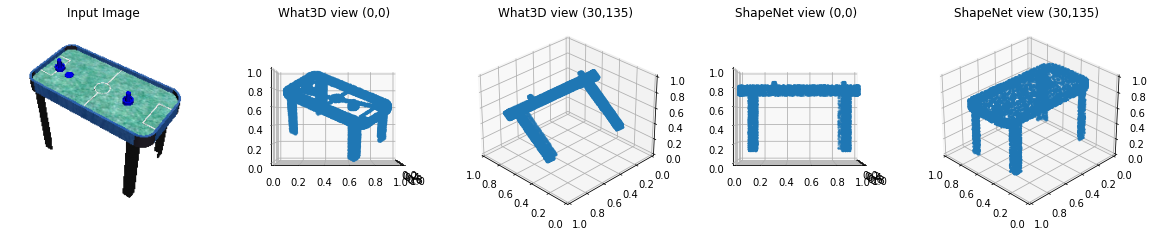

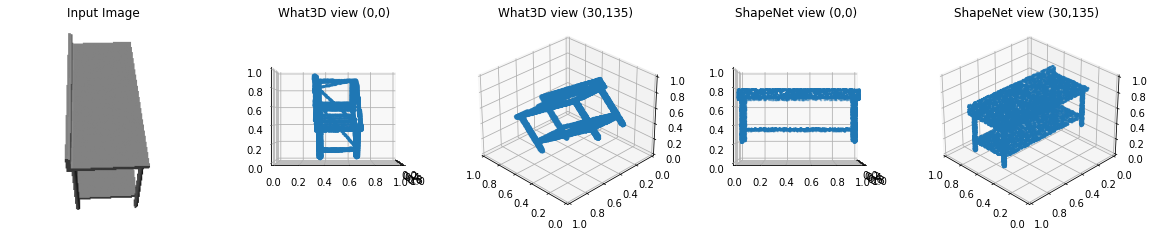

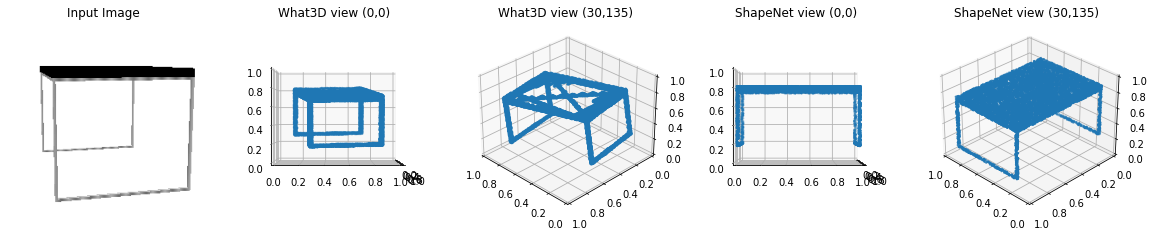

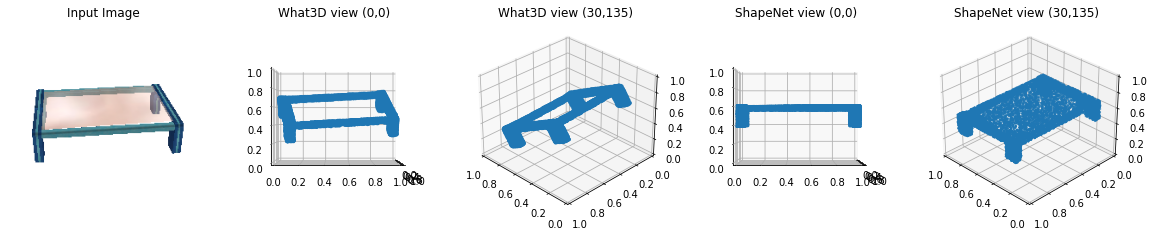

In [20]:
#text_file = open("what3d_samples.txt", "wt")
for index in tqdm.tqdm(range(NUMS), total=NUMS):
    if index in index_list:
        image = cv2.imread(img_path_list[index])
        image = image/255.0
        ## Load GT ##
        what3d_pt = o3d.io.read_point_cloud(what3d_ptcloud_path_list[index], format="auto")
        shapenet_pt = o3d.io.read_point_cloud(shapenet_ptcloud_path_list[index], format="auto")
        ## Normalize GT ##
        what3d_pt = np.asarray(what3d_pt.points)
        shapenet_pt = np.asarray(shapenet_pt.points)
        shapenet_pt = normalize_bbox(shapenet_pt, BBOX)
        data_visualizer(what3d_pt, shapenet_pt, image)
plt.show()

#text_file.write(what3d_ptcloud_path_list[index][[i.start() for i in re.finditer('/', what3d_ptcloud_path_list[index])][1]+1:[i.start() for i in re.finditer('/', what3d_ptcloud_path_list[index])][-1]])
#text_file.write("\n")
#text_file.close()

In [4]:
def data_visualizer(ptcloud, prediction, image):

    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(151)
    if not isinstance(image, np.ndarray):
        image = image[0].transpose(0,1)
        image = image.transpose(1,2)

    ax.imshow(image)
    ax.set_title("Input Image")
    plt.axis("off")

    axis_range = [0, 1]

    if len(ptcloud.shape) == 2:
        ptcloud = np.expand_dims(ptcloud, 0)
    if len(prediction.shape) == 2:
        prediction = np.expand_dims(prediction, 0)
    ax = fig.add_subplot(152, projection='3d')
    ax.scatter(ptcloud[0,:,2], ptcloud[0,:,0], ptcloud[0,:,1], s= 2)
    ax.set_xlim(axis_range)
    ax.set_ylim(axis_range)
    ax.set_zlim(axis_range)
    ax.set_title("What3D view (0,0)")
    #plt.axis("off")
    ax.view_init(0, 0)

    ax = fig.add_subplot(153, projection='3d')
    ax.scatter(ptcloud[0,:,2], ptcloud[0,:,0], ptcloud[0,:,1], s= 2)
    ax.set_xlim(axis_range)
    ax.set_ylim(axis_range)
    ax.set_zlim(axis_range)
    ax.set_title("What3D view (30,135)")
    #plt.axis("off")
    ax.view_init(30, 135)

    ax = fig.add_subplot(154, projection='3d')
    ax.scatter(prediction[0,:,2], prediction[0,:,0], prediction[0,:,1], s= 2)
    ax.set_xlim(axis_range)
    ax.set_ylim(axis_range)
    ax.set_zlim(axis_range)
    ax.set_title("ShapeNet view (0,0)")
    #plt.axis("off")
    ax.view_init(0, 0)

    ax = fig.add_subplot(155, projection='3d')
    ax.scatter(prediction[0,:,2], prediction[0,:,0], prediction[0,:,1], s= 2)
    ax.set_xlim(axis_range)
    ax.set_ylim(axis_range)
    ax.set_zlim(axis_range)
    ax.set_title("ShapeNet view (30,135)")
    #plt.axis("off")
    ax.view_init(30, 135)

In [5]:
def normalize_bbox(ptcloud, bbox, isotropic=True):
    """ normalize pointcloud to a bounding box 
    Params:
    ----------
    ptcloud :  numpy.array
    bbox    :  numpy.array
    isotropic : boolean

    Returns:
    ----------
    ptcloud: numpy.array
    """
    if len(ptcloud.shape) == 2:
        ptcloud = np.expand_dims(ptcloud, axis=0)
    min_vals = np.min(ptcloud, 1, keepdims=True)
    max_vals = np.max(ptcloud, 1, keepdims=True)
    diameter = max_vals - min_vals                # the length of cube 
    if isotropic:
        diameter = np.max(diameter, 2, keepdims=True)
    ptcloud = ptcloud * (1.0 / diameter)
    min_vals = np.min(ptcloud, 1, keepdims=True)
    max_vals = np.max(ptcloud, 1, keepdims=True)
    bbox_center = np.mean(bbox, 1, keepdims=True)
    translation_vector = bbox_center - ((min_vals + max_vals) / 2)
    ptcloud = ptcloud + translation_vector
    
    return ptcloud

In [6]:
def get_class_list() -> list:
    '''Returns the list of ShapeNet class names.'''
    lines = read_txt_file(CLASSES_FILE_PATH)
    lines = [l.split(" ")[0] for l in lines]
    return lines

In [7]:
def read_txt_file(file_path: str) -> list:
    '''Reads a .txt file and returns a list of lines.'''
    with open(file_path) as f:
        lines = f.readlines()
        lines = [l.rstrip() for l in lines]
    return lines